One technique/tool for address unbalanced data is SMOTE.  I've added the original SMOTE paper to the module page (thanks to Esther for digging it out).  I've also linked to the libraries associated with this (contains a whole suite of techniques for unbalanced data).

https://moodle.city.ac.uk/pluginfile.php/2571477/mod_resource/content/1/SMOTE.pdf

https://imbalanced-learn.org/stable/references/index.html



**Plan**: we need to understand correlations:
- **1** 'Severity of Illness' at 'Type of Admission' on 'Stay', those with higher - longer
- **2** if high, then less 'Visitors with Patient'  but long 'Stay'
- **3** prior knowledge of LOS can aid in logistics such as room and bed allocation planning= all high risk together

## Content:
- [Part 1](#part1)- Importing the data set
- [Part 2](#part2)- Exploratory data analysis
- [Part 3](#part3) -  Preparing our data
- [Part 4](#part4) -  Correlation
- [Part 5](#part5) -  Splitting our data for modelling
- [Part 6](#part6) -  Decision tree model (reservation_status included)
- [Part 7](#part7) -  Decision tree model (reservation_status excluded)
- [Part 8](#part8) -  K-nearest neighbours
- [Part 9](#part9) -  Naïve Bayes
- [Part 10](#part10) -  Conclusion
    
P.S. The length of stay - 11 different classes ranging from 0-10 days to more than 100 days.

**Here's a description of what some of the features in the dataframe above represent:**

- `Column`	Description
- `case_id`	Case_ID registered in Hospital
- `Hospital_code`	Unique code for the Hospital
- `Hospital_type_code`	Unique code for the type of Hospital
-`City_Code_Hospital`	City Code of the Hospital
-`Hospital_region_code`	Region Code of the Hospital
-`Available Extra Rooms in Hospital`	Number of Extra rooms available in the Hospital
-`Department`	Department overlooking the case
-`Ward_Type`	Code for the Ward type
-`Ward_Facility_Code`	Code for the Ward Facility
-`Bed Grade`	Condition of Bed in the Ward
-`patientid`	Unique Patient Id
-`City_Code_Patient`	City Code for the patient
-`Type of Admission`	Admission Type registered by the Hospital
-`Severity of Illness`	Severity of the illness recorded at the time of admission
-`Visitors with Patient`	Number of Visitors with the patient
-`Age`	Age of the patient
-`Admission_Deposit`	Deposit at the Admission Time
-`Stay`	Stay Days by the patient


[Back to top](#Content:)


<a id='part1'></a>

### Part 1 -  Importing the data set

In [1]:
import os
# import sys
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
%matplotlib inline

# import tensorflow as tf
# from tensorflow import keras


In [2]:
path = "healthcare"

filename_read = os.path.join(path, "train_data.csv")
df = pd.read_csv(filename_read, na_values=['NA', '?'])

# print(df[0:5])
print(df.shape)
print(df.columns)

(318438, 18)
Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')


In [3]:
df.head(10)

case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0        1              8                  c                   3   
1        2              2                  c                   5   
2        3             10                  e                   1   
3        4             26                  b                   2   
4        5             26                  b                   2   
5        6             23                  a                   6   
6        7             32                  f                   9   
7        8             23                  a                   6   
8        9              1                  d                  10   
9       10             10                  e                   1   

  Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   
3                    Y                                  2  radiotherapy   
4                    Y                                  2  radiotherapy   
5                    X                                  2    anesthesia   
6                    Y                                  1  radiotherapy   
7                    X                                  4  radiotherapy   
8                    Y                                  2    gynecology   
9                    X                                  2    gynecology   

  Ward_Type Ward_Facility_Code  Bed Grade  patientid  City_Code_Patient  \
0         R                  F        2.0      31397                7.0   
1         S                  F        2.0      31397                7.0   
2         S                  E        2.0      31397                7.0   
3         R                  D        2.0      31397                7.0   
4         S                  D        2.0      31397                7.0   
5         S                  F        2.0      31397                7.0   
6         S                  B        3.0      31397                7.0   
7         Q                  F        3.0      31397                7.0   
8         R                  B        4.0      31397                7.0   
9         S                  E        3.0      31397                7.0   

  Type of Admission Severity of Illness  Visitors with Patient    Age  \
0         Emergency             Extreme                      2  51-60   
1            Trauma             Extreme                      2  51-60   
2            Trauma             Extreme                      2  51-60   
3            Trauma             Extreme                      2  51-60   
4            Trauma             Extreme                      2  51-60   
5            Trauma             Extreme                      2  51-60   
6         Emergency             Extreme                      2  51-60   
7            Trauma             Extreme                      2  51-60   
8            Trauma             Extreme                      2  51-60   
9            Trauma             Extreme                      2  51-60   

   Admission_Deposit   Stay  
0             4911.0   0-10  
1             5954.0  41-50  
2             4745.0  31-40  
3             7272.0  41-50  
4             5558.0  41-50  
5             4449.0  11-20  
6             6167.0   0-10  
7             5571.0  41-50  
8             7223.0  51-60  
9             6056.0  31-40

[Back to top](#Content:)

<a id='part2'></a>
### Part 2- Exploratory data analysis (EDA)

In [4]:
#creating a copy of df to have an original for further manipulation
new_df = df.copy()
new_df = new_df.select_dtypes(include=["int","float"])

headers = list(new_df.columns.values)

In [5]:
fields = []
for field in headers:
    fields.append({
        "name":field,
        "mean":df[field].mean(),
        "var":df[field].var(),
        "sdev":df[field].std()
    })
for field in fields:
    print(field)

{'name': 'case_id', 'mean': 159219.5, 'var': 8450256523.484579, 'sdev': 91925.27684747313}
{'name': 'Hospital_code', 'mean': 18.318840716246175, 'var': 74.54172342795314, 'sdev': 8.633754885792921}
{'name': 'City_Code_Hospital', 'mean': 4.771716943329627, 'var': 9.62572562697152, 'sdev': 3.102535354669068}
{'name': 'Available Extra Rooms in Hospital', 'mean': 3.1976271676119055, 'var': 1.364624484865746, 'sdev': 1.1681714278588335}
{'name': 'Bed Grade', 'mean': 2.625806958297338, 'var': 0.7623835960741749, 'sdev': 0.873145804590605}
{'name': 'patientid', 'mean': 65747.57947229916, 'var': 1442475571.9882374, 'sdev': 37979.93644002367}
{'name': 'City_Code_Patient', 'mean': 7.251858836721821, 'var': 22.517545245763493, 'sdev': 4.745265561142337}
{'name': 'Visitors with Patient', 'mean': 3.2840992595104854, 'var': 3.1119125861261314, 'sdev': 1.7640613895571013}
{'name': 'Admission_Deposit', 'mean': 4880.749392346391, 'var': 1181082.625479292, 'sdev': 1086.7762536416094}


#????**here should an analysis of columns means and st dev**

Missing Values

In [6]:
#checking for missing values
df.isnull().values.any()

True

In [7]:
#Checking number of NANs for each column, in order to understand how many missing values there are in a dataframe.
print("# of NaN in each columns:", df.isnull().sum(), sep='\n')

# of NaN in each columns:
case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64


To make sure we consider all the correct features to make an accurate prediction, it may be useful to create some plots to have a better understanding of our data.

we will be using the Python data visualisation library seaborn. 

We could begin by visualising the length of stays by type of admissions etc., by using a countplot(), that shows the counts of observations in each categorical bin using bars.

In [8]:
#sorting by Stay for better representation in the visualisations
df= df.sort_values(by = "Stay", ascending = True)
df.head(10)

case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0             1              8                  c                   3   
136814   136815             28                  b                  11   
136815   136816             29                  a                   4   
136823   136824             11                  b                   2   
136837   136838             14                  a                   1   
136845   136846              1                  d                  10   
136846   136847              1                  d                  10   
136847   136848             12                  a                   9   
136866   136867             14                  a                   1   
136874   136875              6                  a                   6   

       Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                         Z                                  3  radiotherapy   
136814                    X                                  2    gynecology   
136815                    X                                  3    gynecology   
136823                    Y                                  4    gynecology   
136837                    X                                  3    gynecology   
136845                    Y                                  3  radiotherapy   
136846                    Y                                  2  radiotherapy   
136847                    Y                                  5    gynecology   
136866                    X                                  2    gynecology   
136874                    X                                  2    gynecology   

       Ward_Type Ward_Facility_Code  Bed Grade  patientid  City_Code_Patient  \
0              R                  F        2.0      31397                7.0   
136814         R                  F        3.0     112307                1.0   
136815         S                  F        3.0     112307                1.0   
136823         Q                  D        4.0      64198               14.0   
136837         R                  E        3.0      76865                1.0   
136845         S                  B        4.0      19181                7.0   
136846         S                  B        4.0      19181                7.0   
136847         Q                  B        1.0      19181                7.0   
136866         R                  E        3.0     101538                8.0   
136874         Q                  F        3.0      40220                8.0   

       Type of Admission Severity of Illness  Visitors with Patient    Age  \
0              Emergency             Extreme                      2  51-60   
136814         Emergency            Moderate                      2  21-30   
136815         Emergency            Moderate                      2  21-30   
136823         Emergency            Moderate                      2  21-30   
136837         Emergency             Extreme                      3  51-60   
136845         Emergency               Minor                      2  51-60   
136846         Emergency               Minor                      2  51-60   
136847            Urgent            Moderate                      4  51-60   
136866         Emergency            Moderate                      3  51-60   
136874         Emergency            Moderate                      4  71-80   

        Admission_Deposit  Stay  
0                  4911.0  0-10  
136814             4517.0  0-10  
136815             3846.0  0-10  
136823             5183.0  0-10  
136837             3452.0  0-10  
136845             3908.0  0-10  
136846             3934.0  0-10  
136847             3410.0  0-10  
136866             4222.0  0-10  
136874             5746.0  0-10

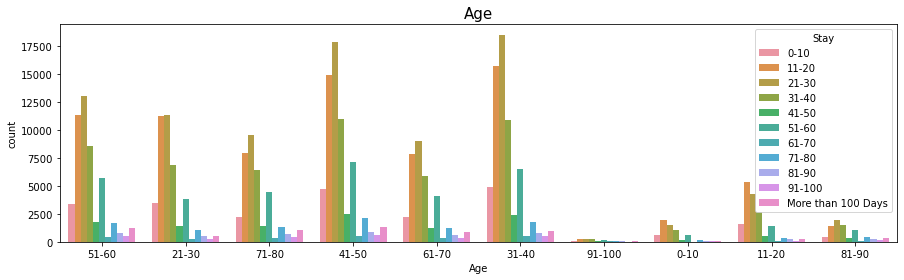

In [9]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Age", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Age", hue = 'Stay', data = df)

In [10]:
#?? comments
#the age group risk - 21-80y.o.

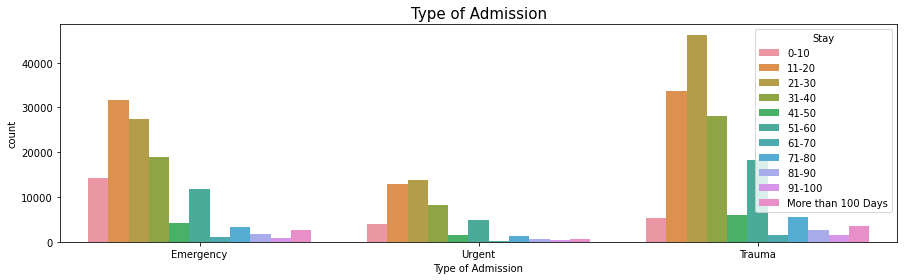

In [11]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Type of Admission", fontdict = {'fontsize': 15})
ax = sns.countplot(x = "Type of Admission", hue = 'Stay', data = df)


???? comments on the graph


Emergency and Trauma and mostly from 11 - 40  and range 51-60 


Next, it may be interesting to look at the Severity of Illness segments by stay.

Again, we can use a count plot to visualise this.

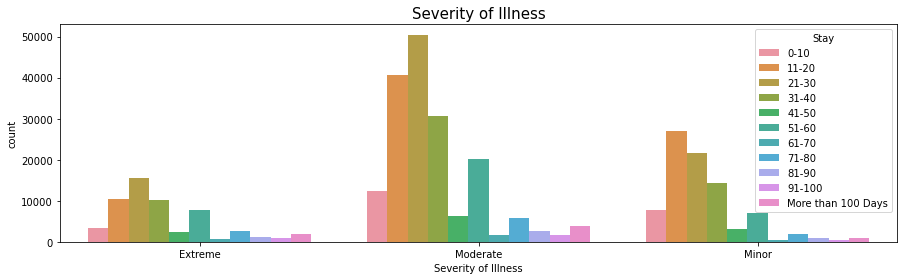

In [12]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Severity of Illness", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Severity of Illness", hue = 'Stay', data = df)

???? comments on the graph: 


mostly moderate and minor, and in age range 11-40  and range 51-60 


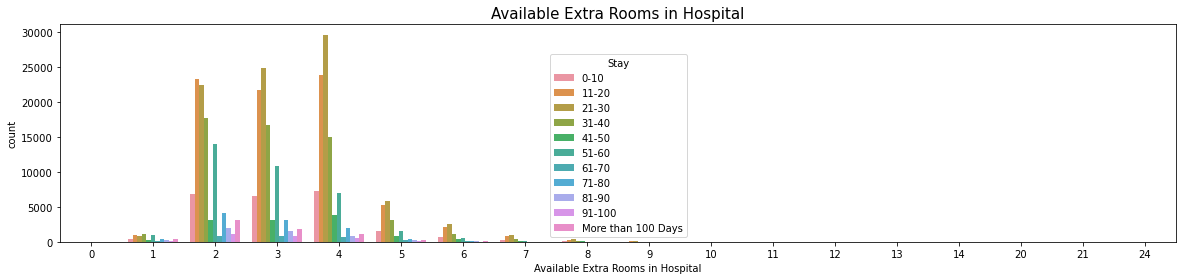

In [13]:
#plot size
plt.figure(figsize = (20,4))
#plot title
plt.title("Available Extra Rooms in Hospital", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Available Extra Rooms in Hospital", hue = 'Stay', data = df)

???? comments on the graph

most rooms have additional 2-4 beds in the room available.

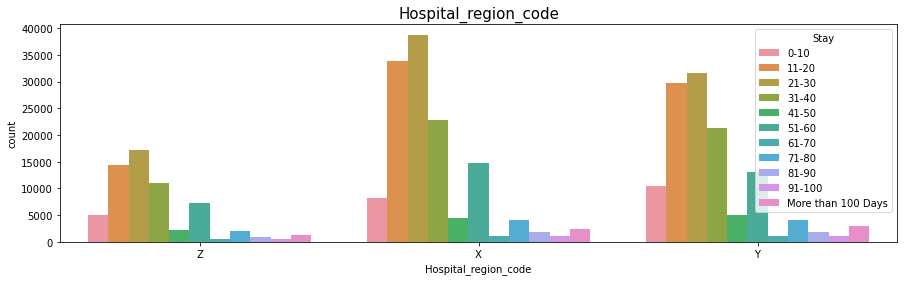

In [14]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Hospital_region_code", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Hospital_region_code", hue = 'Stay', data = df)

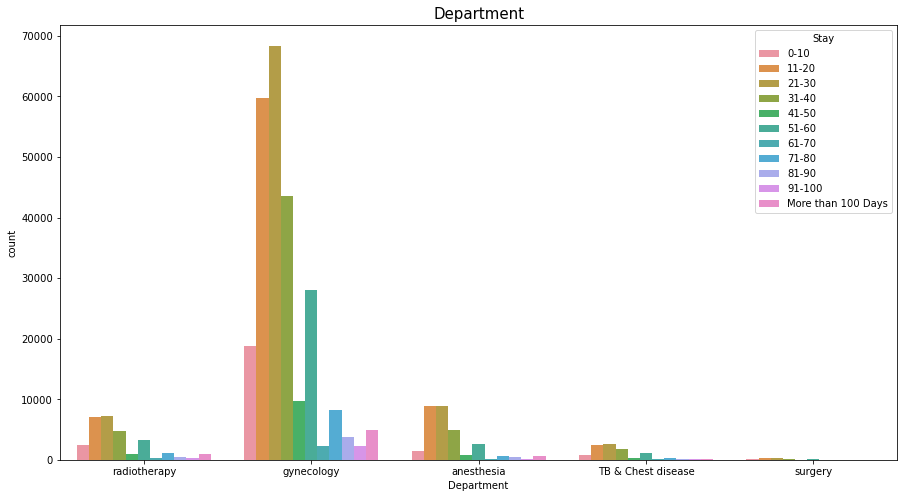

In [15]:
#plot size
plt.figure(figsize = (15,8))
#plot title
plt.title("Department", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Department", hue = 'Stay', data = df)

In [16]:
#??? commments
#mostly gynecology department

[Back to top](#Content:)

<a id='part3'></a>
### Part 3 - Preparing our data

We saw in Part 2 that columns **"Bed Grade"** and **"City_Code_patient"** have missing values. Before deciding whether we shall drop these columns or keep some of them and try to fill the missing values with medians, we can make and analysis to understand the percentage of missing values by creating this function **"perc_mv"**.


In [17]:
def perc_mv(x, y):
    perc = y.isnull().sum() / len(x) * 100
    return perc

In [18]:
print('Missing value ratios:\nBed Grade: {}\nCity_Code_Patient: {}'.format(
    perc_mv(df, df['Bed Grade']),
    perc_mv(df, df['City_Code_Patient'])))

Missing value ratios:
Bed Grade: 0.035485714644609
City_Code_Patient: 1.4231969802598936


**As we can see, 0.03% of Bed Grade column and 1.42% of City_Code_Patient has missing values. Therefore, we have enough values to fill the rows of the company column via any imputation method.**

In [19]:
# Assuming importance of the City_Code_Patient in the future analysis is minimalistic
# let s drop it 

df = df.drop(['City_Code_Patient'], axis = 1)

In [20]:
#let's fill missing values of 'Bed Grade' with its median of the column
med = df['Bed Grade'].median()
df['Bed Grade'] = df['Bed Grade'].fillna(med)

In [21]:
#missing values check after data manipulation
df.isnull().values.any()

False

Next, we may want to check the features to create some more meaningful variables and reduce the number of features.


In [22]:
#????think of smth to work on the type
#In the code cell below, we use the attribute dtype on df to retrieve the data type for each column.
print (df.dtypes)

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object


In [23]:
#We want to map the name of each Severity of Illness to the corresponding number in ascending order.
df['Severity of Illness'] = df['Severity of Illness'].map({'Minor':1, 'Moderate': 2, 'Extreme':3})
df['Type of Admission'] = df['Type of Admission'].map({'Trauma':1, 'Emergency': 2, 'Urgent':3})
df

case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0             1              8                  c                   3   
136814   136815             28                  b                  11   
136815   136816             29                  a                   4   
136823   136824             11                  b                   2   
136837   136838             14                  a                   1   
...         ...            ...                ...                 ...   
68359     68360             10                  e                   1   
15335     15336             18                  d                  13   
15334     15335             18                  d                  13   
31499     31500             26                  b                   2   
209789   209790             26                  b                   2   

       Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                         Z                                  3  radiotherapy   
136814                    X                                  2    gynecology   
136815                    X                                  3    gynecology   
136823                    Y                                  4    gynecology   
136837                    X                                  3    gynecology   
...                     ...                                ...           ...   
68359                     X                                  2    gynecology   
15335                     Y                                  2    gynecology   
15334                     Y                                  2    gynecology   
31499                     Y                                  2    gynecology   
209789                    Y                                  2  radiotherapy   

       Ward_Type Ward_Facility_Code  Bed Grade  patientid  Type of Admission  \
0              R                  F        2.0      31397                  2   
136814         R                  F        3.0     112307                  2   
136815         S                  F        3.0     112307                  2   
136823         Q                  D        4.0      64198                  2   
136837         R                  E        3.0      76865                  2   
...          ...                ...        ...        ...                ...   
68359          S                  E        3.0     113737                  1   
15335          R                  B        3.0      17210                  1   
15334          R                  B        3.0      17210                  1   
31499          Q                  D        3.0      79939                  1   
209789         R                  D        4.0     104594                  1   

        Severity of Illness  Visitors with Patient    Age  Admission_Deposit  \
0                         3                      2  51-60             4911.0   
136814                    2                      2  21-30             4517.0   
136815                    2                      2  21-30             3846.0   
136823                    2                      2  21-30             5183.0   
136837                    3                      3  51-60             3452.0   
...                     ...                    ...    ...                ...   
68359                     2                      6  61-70             4345.0   
15335                     2                      8  71-80             4413.0   
15334                     2                      8  71-80             3080.0   
31499                     2                     20  51-60             5087.0   
209789                    3                     12  51-60             5303.0   

                      Stay  
0                     0-10  
136814                0-10  
136815                0-10  
136823                0-10  
136837                0-10  
...                    ...  
68359   More than 100 Days  
15335   More tha

For now, we assume these columns are not important for our analysis:

0case_id

1Hospital_code 

2Hospital_type_code

3City_Code_Hospital  

7Ward_Type - anyways we know department, so we can guess the ward type

8Ward_Facility_Code

In [24]:
#dropping unwanted columns
df.drop(df.columns[0:4],axis=1, inplace=True)
df.drop(df.columns[3:5], axis=1, inplace=True)
print(df.shape)
df

(318438, 11)


Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                         Z                                  3  radiotherapy   
136814                    X                                  2    gynecology   
136815                    X                                  3    gynecology   
136823                    Y                                  4    gynecology   
136837                    X                                  3    gynecology   
...                     ...                                ...           ...   
68359                     X                                  2    gynecology   
15335                     Y                                  2    gynecology   
15334                     Y                                  2    gynecology   
31499                     Y                                  2    gynecology   
209789                    Y                                  2  radiotherapy   

        Bed Grade  patientid  Type of Admission  Severity of Illness  \
0             2.0      31397                  2                    3   
136814        3.0     112307                  2                    2   
136815        3.0     112307                  2                    2   
136823        4.0      64198                  2                    2   
136837        3.0      76865                  2                    3   
...           ...        ...                ...                  ...   
68359         3.0     113737                  1                    2   
15335         3.0      17210                  1                    2   
15334         3.0      17210                  1                    2   
31499         3.0      79939                  1                    2   
209789        4.0     104594                  1                    3   

        Visitors with Patient    Age  Admission_Deposit                Stay  
0                           2  51-60             4911.0                0-10  
136814                      2  21-30             4517.0                0-10  
136815                      2  21-30             3846.0                0-10  
136823                      2  21-30             5183.0                0-10  
136837                      3  51-60             3452.0                0-10  
...                       ...    ...                ...                 ...  
68359                       6  61-70             4345.0  More than 100 Days  
15335                       8  71-80             4413.0  More than 100 Days  
15334                       8  71-80             3080.0  More than 100 Days  
31499                      20  51-60             5087.0  More than 100 Days  
209789                     12  51-60             5303.0  More than 100 Days  

[318438 rows x 11 columns]

In [25]:
#using LabelEncoder to change and transform the object format of 
#'Hospital_region_code','Department','Age', 'Stay' columns
le = LabelEncoder()
for col in ['Hospital_region_code','Department','Age', 'Stay']:
    df[col]= df[col].astype('str')
    df[col]= le.fit_transform(df[col])
print (df.dtypes)

Hospital_region_code                   int32
Available Extra Rooms in Hospital      int64
Department                             int32
Bed Grade                            float64
patientid                              int64
Type of Admission                      int64
Severity of Illness                    int64
Visitors with Patient                  int64
Age                                    int32
Admission_Deposit                    float64
Stay                                   int32
dtype: object


In [26]:
#shuffling
df= df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

[Back to top](#Content:)

<a id='part4'></a>
### Part 4 - Correlation

In [27]:
#creating a copy of df to have an original for further manipulation
cor_df = df.copy()

In [28]:
# using from sklearn.preprocessing LabelEncoder 

In [29]:
cor_df['Stay'] = le.fit_transform(cor_df['Stay']) 

In [30]:
#use corr() on cor_df
cor_df.corr()

Hospital_region_code  \
Hospital_region_code                           1.000000   
Available Extra Rooms in Hospital             -0.006906   
Department                                     0.041499   
Bed Grade                                     -0.042680   
patientid                                     -0.002083   
Type of Admission                              0.058217   
Severity of Illness                            0.029454   
Visitors with Patient                         -0.019485   
Age                                           -0.017083   
Admission_Deposit                              0.075092   
Stay                                           0.011905   

                                   Available Extra Rooms in Hospital  \
Hospital_region_code                                       -0.006906   
Available Extra Rooms in Hospital                           1.000000   
Department                                                  0.047726   
Bed Grade                                                  -0.115804   
patientid                                                   0.000921   
Type of Admission                                           0.041737   
Severity of Illness                                        -0.003307   
Visitors with Patient                                       0.096714   
Age                                                        -0.133491   
Admission_Deposit                                          -0.143739   
Stay                                                       -0.121120   

                                   Department  Bed Grade  patientid  \
Hospital_region_code                 0.041499  -0.042680  -0.002083   
Available Extra Rooms in Hospital    0.047726  -0.115804   0.000921   
Department                           1.000000  -0.096745   0.002217   
Bed Grade                           -0.096745   1.000000   0.001638   
patientid                            0.002217   0.001638   1.000000   
Type of Admission                    0.052736  -0.049850   0.004391   
Severity of Illness                  0.004872  -0.284407  -0.006397   
Visitors with Patient                0.026054   0.088920   0.006889   
Age                                  0.035518   0.001717  -0.001505   
Admission_Deposit                   -0.080754   0.073779  -0.000877   
Stay                                 0.033287   0.025761   0.001125   

                                   Type of Admission  Severity of Illness  \
Hospital_region_code                        0.058217             0.029454   
Available Extra Rooms in Hospital           0.041737            -0.003307   
Department                                  0.052736             0.004872   
Bed Grade                                  -0.049850            -0.284407   
patientid                                   0.004391            -0.006397   
Type of Admission                           1.000000            -0.047165   
Severity of Illness                        -0.047165             1.000000   
Visitors with Patient                      -0.021020             0.047292   
Age                                        -0.100903             0.125232   
Admission_Deposit                          -0.075895            -0.070892   
Stay                                       -0.084072             0.126160   

                                   Visitors with Patient       Age  \
Hospital_region_code                           -0.019485 -0.017083   
Available Extra Rooms in Hospital               0.096714 -0.133491   
Department                                      0.026054  0.035518   
Bed Grade                                       0.088920  0.001717   
patientid                                       0.006889 -0.001505   
Type of Admission                              -0.021020 -0.100903   
Severity of Illness                             0.047292  0.125232   
Visitors with Patient                           1.000000  0.073795   
Age                                             0.073

In [31]:
#Because we want to try to predict the likelihood of a length of stay depending on the type of admission, it is useful to visualise the sorted correlation values for the column Type of Admission.
# here, we are appling sort_values() to visualise the correlation values in a descending order.
cor_df.corr()['Type of Admission'].sort_values(ascending=False)

Type of Admission                    1.000000
Hospital_region_code                 0.058217
Department                           0.052736
Available Extra Rooms in Hospital    0.041737
patientid                            0.004391
Visitors with Patient               -0.021020
Severity of Illness                 -0.047165
Bed Grade                           -0.049850
Admission_Deposit                   -0.075895
Stay                                -0.084072
Age                                 -0.100903
Name: Type of Admission, dtype: float64

In [32]:
#let's examine likelihood of a length of stay depending on the Severity of Illness.

cor_df.corr()['Severity of Illness'].sort_values(ascending=False)

Severity of Illness                  1.000000
Stay                                 0.126160
Age                                  0.125232
Visitors with Patient                0.047292
Hospital_region_code                 0.029454
Department                           0.004872
Available Extra Rooms in Hospital   -0.003307
patientid                           -0.006397
Type of Admission                   -0.047165
Admission_Deposit                   -0.070892
Bed Grade                           -0.284407
Name: Severity of Illness, dtype: float64

In [33]:
#???What is the most impactful feature?

[Back to top](#Content:)


<a id='part5'></a>

## Part 5 - Splitting our data for modelling

In [34]:
#using from sklearn.model_selection import train_test_split model

In [35]:
X = df.drop(columns=["Stay"])
y = df["Stay"]
print(X.shape)
print(y.shape)


(318438, 10)
(318438,)


In [36]:
#test size = 20%, train size = 80%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [37]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()

# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)


In [38]:
# #creating Perceptron
# ppn = Perceptron(max_iter=40, tol = 0.001, eta0=1)

In [39]:
# #train the model
# ppn.fit(X_train_std, y_train)

In [40]:
# #make prediction
# y_pred = ppn.predict(X_test_std)

In [41]:
# #accuracy
# print('Accuracy: %.2f' %accuracy_score(y_test,y_pred)) -20smth %, need to work on it 

In [1]:
# from sklearn.model_selection import KFold
# from sklearn.tree import DecisionTreeClassifier
# decision_tree = DecisionTreeClassifier (criterion = "entropy")


# kf = KFold(5)
# fold = 1
# for train_index, validate_index in kf.split(X,y):
#     decision_tree.fit(X[train_index], y[train_index])
#     y_test= y[validate_index]
#     y_pred = decision_tree.predict(X[validate_index])
#     print (f"Fold #{fold}, Training Size: {len(X[train_index])}, Validation Size: {len(X[validate_index])}")
#     print("Accuracy: %.2f" %accuracy_score(y_test,y_pred))